In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, ncx2, norm
from scipy.integrate import quad
import math

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def simulate(Nsyms, m, EsN0):
    sigma = np.sqrt(0.5/EsN0)
    x = sigma*(np.random.randn(Nsyms, m) + 1j*np.random.randn(Nsyms, m))
    x[:, 0] += 1
    coherent_detect = np.argmax(x.real, axis=1)
    noncoherent_detect = np.argmax(np.abs(x), axis=1)
    return coherent_detect, noncoherent_detect, m

def coherent_ser(coh, noncoh, m):
    return np.average(coh != 0)

def noncoherent_ser(coh, noncoh, m):
    return np.average(noncoh != 0)

def lrtc_ber(coh, noncoh, m):
    return np.average(noncoh >= m//2)

def hamming_weight(x):
    return bin(x)[2:].count('1')
    
def coherent_ber(coh, noncoh, m):
    return np.average([hamming_weight(x) for x in coh])/np.log2(m)

def noncoherent_ber(coh, noncoh, m):
    return np.average([hamming_weight(x) for x in noncoh])/np.log2(m)

def do_all(coh, noncoh, m):
    funcs = [coherent_ser, noncoherent_ser,
             coherent_ber, noncoherent_ber,
             lrtc_ber]
    return [f(coh, noncoh, m) for f in funcs]

def integrand_coh(x, EsN0, m):
    return norm.pdf(x - np.sqrt(2*EsN0)) * norm.cdf(x)**(m - 1)
    
def integrand_noncoh(x, EsN0, m):
    return ncx2.pdf(x, 2, 2*EsN0) * chi2.cdf(x, 2)**(m - 1)

def coherent_ser_formula(EsN0, m):
    return 1 - quad(integrand_coh, args = (EsN0, m), a = -np.inf, b = +np.inf)[0]

def noncoherent_ser_formula(EsN0, m):
    return 1 - quad(integrand_noncoh, args = (EsN0, m), a = -np.inf, b = +np.inf)[0]

def coherent_ber_formula(EsN0, m):
    return m/(2*m-2) * coherent_ser_formula(EsN0, m)

def noncoherent_ber_formula(EsN0, m):
    return m/(2*m-2) * noncoherent_ser_formula(EsN0, m)

def do_all_formulas(EsN0, m):
    formulas = [coherent_ser_formula, noncoherent_ser_formula,
                coherent_ber_formula, noncoherent_ber_formula]
    return [f(EsN0, m) for f in formulas]

In [3]:
%%time
m = 32
Nsyms = 1000000

EsN0s = np.logspace(0, 1.5, 30)
sim = np.array([do_all(*simulate(Nsyms, m, EsN0)) for EsN0 in EsN0s])

CPU times: user 40.9 s, sys: 4.06 s, total: 44.9 s
Wall time: 45.1 s


In [4]:
%%time
EsN0s_formula = np.logspace(0, 1.5, 300)
formulas = np.array([do_all_formulas(EsN0, m) for EsN0 in EsN0s_formula])

CPU times: user 44.8 s, sys: 887 ms, total: 45.7 s
Wall time: 44.6 s


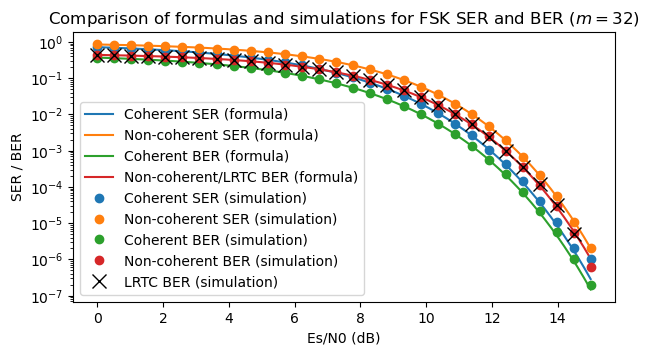

In [5]:
legend = [
    'Coherent SER (formula)', 'Non-coherent SER (formula)',
    'Coherent BER (formula)', 'Non-coherent/LRTC BER (formula)',
    'Coherent SER (simulation)', 'Non-coherent SER (simulation)',
    'Coherent BER (simulation)', 'Non-coherent BER (simulation)',
    'LRTC BER (simulation)']
plt.semilogy(10*np.log10(EsN0s_formula), formulas)
plt.gca().set_prop_cycle(None)
plt.semilogy(10*np.log10(EsN0s), sim[:, :-1], 'o')
plt.semilogy(10*np.log10(EsN0s), sim[:, -1], 'x', markersize=10, color='black');
plt.legend(legend)
plt.title(f'Comparison of formulas and simulations for FSK SER and BER ($m = {m}$)')
plt.xlabel('Es/N0 (dB)')
plt.ylabel('SER / BER');

In [6]:
%%time
ms = [2, 4, 8, 16, 32]
sim_noncoherent_ser = np.array([[noncoherent_ser(*simulate(Nsyms, m, EsN0)) for EsN0 in EsN0s] for m in ms])

CPU times: user 1min 4s, sys: 7.44 s, total: 1min 11s
Wall time: 1min 11s


In [7]:
def noncoherent_ser_closed_formula(EsN0, m):
    return sum(math.comb(m - 1, k) * (-1)**(k+1)/(k+1) * np.exp(-EsN0*k/(k+1)) for k in range(1, m))

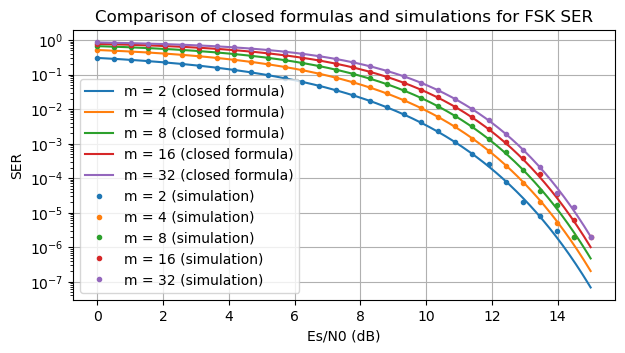

In [8]:
plt.semilogy(10*np.log10(EsN0s_formula), np.array([noncoherent_ser_closed_formula(EsN0s_formula, m) for m in ms]).T)
plt.gca().set_prop_cycle(None)
plt.semilogy(10*np.log10(EsN0s), sim_noncoherent_ser.T, '.')
plt.legend([f'm = {m} (closed formula)' for m in ms] + [f'm = {m} (simulation)' for m in ms])
plt.grid()
plt.title(f'Comparison of closed formulas and simulations for FSK SER')
plt.xlabel('Es/N0 (dB)')
plt.ylabel('SER');

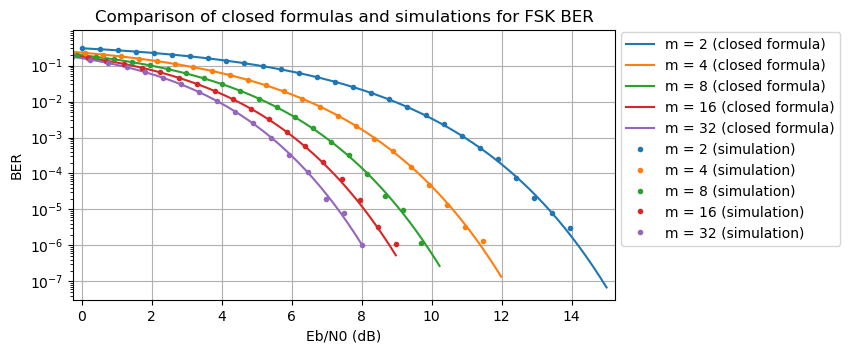

In [9]:
for m in ms:
    plt.semilogy(10*np.log10(EsN0s_formula/np.log2(m)), m / (2 * (m - 1)) * noncoherent_ser_closed_formula(EsN0s_formula, m))
plt.gca().set_prop_cycle(None)
for j, m in enumerate(ms):
    plt.semilogy(10*np.log10(EsN0s/np.log2(m)), m / (2 * (m - 1)) * sim_noncoherent_ser[j], '.')
plt.legend([f'm = {m} (closed formula)' for m in ms] + [f'm = {m} (simulation)' for m in ms], loc=(1.01,0.2))
plt.grid()
plt.title(f'Comparison of closed formulas and simulations for FSK BER')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.xlim(-0.25, 15.25);